<H1 style="text-align: center">Interactive Image Generator</H1>

# **PREREQUISITE**

In [1]:
!pip install -q git+https://github.com/ranjaykrishna/visual_genome_python_driver.git

In [2]:
!pip install ujson

In [3]:
!pip install -q git+https://github.com/fabriziocosta/EDeN.git 

In [4]:
!pip install -q opencv-python

In [5]:
!pip install six

In [6]:
# Import all required library 
import visual_genome.local as vgl
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance
import numpy as np 
import os
from skimage import data
from skimage.restoration import inpaint
from sklearn import metrics
from tqdm import tqdm,trange
import urllib


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from networkx.readwrite import json_graph
from eden.graph import vectorize
import ujson as json
from collections import Counter
import cv2

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import random

import warnings
warnings.filterwarnings("ignore")


# **Scene Graph**

In [7]:
# This code was inspired by Dennis Harrop
def scene_network(scene_graph):
    """ 
    Create a networkx scene network of a scene graph json file.
    Input: 
        scene_graph - the scene graph    
    Output:
        network - a Directed networkx graph
    """
    width = scene_graph.image.width
    height = scene_graph.image.height
    dist = 10
    near = 2.5
    x_distance = width * dist
    y_distance = height * dist
    
    network = nx.DiGraph(w=width, h=height, url=scene_graph.image.url, id=scene_graph.image.id)

    for r in scene_graph.relationships:
        subject_x = int(r.subject.x / x_distance)
        subject_y = int(r.subject.y / y_distance)
        object_x = int(r.object.x / x_distance)
        object_y = int(r.object.y / y_distance)
        subject_object_dist = int((((object_x - subject_x) ** 2 + (object_y - subject_y) ** 2)) ** 0.5)

        network.add_edge(
            r.subject.id, r.object.id, label=r.predicate, weight=subject_object_dist)

    for o in scene_graph.objects:
        attributes = {d: 1 for d in o.attributes}
        regions = {d: 1 for d in o.attributes}
        pos1 = {
            "x": int(o.x / width * dist),
            "y": int(o.y / height * dist),
            "w": int(o.width / width * dist),
            "h": int(o.height / height * dist),
        }
        attributes.update(pos1)

        pos2 = {
            "x": int(o.x),
            "y": int(o.y),
            "w": int(o.width),
            "h": int(o.height),
        }
        regions.update(pos2)
        
        network.add_node(o.id, label=str(o), svec=attributes,regions = regions )

    use_minimum_spanning_tree(network)

    return network

# This code was inspired by Dennis Harrop
def use_minimum_spanning_tree(scene_network):
    """ 
    Create a new networkx scene network of a scene graph using kruskal's minimum spanning tree.
    Input: 
        scene_network - a scene network where all nodes are connectedd to each other.   
    Output:
        network - a minium spanning tree of the input graph (Directed networkx graph).
    """
    temp = nx.Graph()
    width = scene_network.graph["w"]
    height = scene_network.graph["h"]

    attribs = nx.get_node_attributes(scene_network, "svec")
    edges = list(itertools.combinations(scene_network.nodes, 2))
    for a, b in edges:
        x1 = attribs[a]["x"]
        y1 = attribs[a]["y"]
        x2 = attribs[b]["x"]
        y2 = attribs[b]["y"]
        dist = int((((x2 - x1) ** 2 + (y2 - y1) ** 2)) ** 0.5)
        temp.add_edge(a, b, label="BESIDE", weight=dist)
    temp = nx.minimum_spanning_tree(temp)

    for a, b, g in temp.edges(data=True):
        if not scene_network.has_edge(a, b):
            scene_network.add_edge(a, b, label=g["label"], weight=g["weight"])
        if not scene_network.has_edge(a, b):
            scene_network.add_edge(a, b, label=g["label"], weight=g["weight"])


# This code was inspired by Dennis Harrop          
def visualize_network(graph, image = True):
    """ 
    Display the scene network and the image of interest.
    Input: 
        graph - The scene network created.
        image - Determine whether to show the image or not
    Output:
        network - Plot a Directed networkx graph and image (optional).
    """
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    vertices_labels = nx.get_node_attributes(graph, "label")
    edge_labels = nx.get_edge_attributes(graph, "label")
   
    width = nx.get_edge_attributes(graph, "weight")

    near_edges = [(a, b, d) for a, b, d in edges if d["label"] == "NEAR"]
    for a, b, _ in near_edges:
        del edge_labels[(a, b)]
         
    f = urllib.request.urlopen(graph.graph["url"])
    img = Image.open(f)
    ax = plt.gca()
    
    
    plt.title('Scene Network')   
    pos = nx.spring_layout(graph)

    node_size = 200
    nx.draw_networkx_nodes(graph, pos, node_color="g", node_size=node_size, alpha=0.4)
    nx.draw_networkx_labels(graph, pos, vertices_labels, font_size=12)
    nx.draw_networkx_edges(
        graph, pos, edgelist=edge_labels, width=1.0, alpha=1, node_size=node_size
    )
    nx.draw_networkx_edges(
        graph,
        pos,
        edgelist=near_edges,
        width=1.0,
        alpha=0.3,
        edge_color="b",
        node_size=node_size,arrowsize=10
    )
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    

    if (image):
        _, ax = plt.subplots(ncols = 1)
        ax.set_title('Scene Image')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.imshow(img)
        plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()
    




# **Get selected images from user preference**

In [8]:
def get_selected_images(preference_list):
    """ 
    Create a list containd images ids of interest.
    Input: 
        preference_list - A list of objects the user likes.
    Output:
        interested_graphs - A list of interested graph ids.
    """
    image_ids = vgl.get_all_image_data(data_dir= 'data/')
    imgs = {img.id: img for img in image_ids}
    interested_graphs = []
    images_id = list(imgs.keys())
    for id in images_id:
        temp = False
        data = json.load(open(f"data/by-id/{id}.json"))
        sample = vgl.parse_graph_local(data, imgs[id])
        for obj in sample.objects:
            for label in obj.names:
                if label.lower() in preference_list:
                    interested_graphs.append(id)
                    temp = True
                    break
            if temp:
                break


    if len(interested_graphs) > 0:
        write_ids_file(interested_graphs,preference_list) # write in to a text file
        return interested_graphs
    
    else:
        print("No image contains this preference")

def write_ids_file(ids,preference):
    """ 
    Write the images ids into a file.
    Input: 
        preference_list - A list of objects the user likes.
        ids -  A list of image ids.
    """
    newpath = r'data/my_data' 
    if not os.path.exists(newpath):
            os.makedirs(newpath)
    with open(f"{newpath}/chosen_{preference}_ids", "w") as line:
        for x in ids:
            line.write(str(x))
            line.write("\n")
    
def read_id_file(preference):
    """ 
    Read image ids from file and add it to a list.
    Input: 
        preference- A list of objects the user likes.
    Output:
        interested_graphs - A list of interested graph ids.
    """
    newpath = f'data/my_data/chosen_{preference}_ids'
    with open(f"{newpath}", "r") as file:
        info = str(file.read())
        id_list = list(map(int, info.strip().split("\n")))
    return id_list

def create_selected_graphs(preference_List):
    """ 
    Create a list containd images ids of interest.
    Input: 
        preference_list - A list of objects the user likes.
    Output:
        interested_graphs - A list of interested graph ids.
    """
    image_ids = vgl.get_all_image_data(data_dir= 'data/')
    imgs = {img.id: img for img in image_ids}

    try:
        output_ids = read_id_file(preference_List)
    except IOError:
        output_ids = get_selected_images(preference_List)
        
    for id in trange(len(output_ids)):
        info = json.load(open(f"data/by-id/{output_ids[id]}.json"))
        graph_local = vgl.parse_graph_local(info, imgs[output_ids[id]])
        G = scene_network(graph_local) # Turn those data into graphs
        new_id = graph_local.image.id
        info = json_graph.node_link_data(G)

        with open(f"data/my_data/{new_id}.json", "w") as file:
            file.write(json.dumps(info))

            
def graph_reader(preference):
    graphs = []
    tally = 0
    path = f'data/my_data/chosen_{preference}_ids'
    if os.path.isfile(path):
        for entry in tqdm(os.scandir("data/my_data")):
            if entry.name.endswith("json"):
                with open(entry, "r") as f:
                    graphs.append(json_graph.node_link_graph(json.loads(f.read())))
            tally += 1
    return graphs



# **Check graph correctness**

In [9]:
def check_networkx_graph(graph):
    """Chechking the input type."""
    assert isinstance(graph, nx.classes.graph.Graph), "This is not a NetworkX graph."


def check_directedness(graph):
    """Checking the undirected nature of a single graph."""
    directed = nx.is_directed(graph)
    assert directed == False, "Graph is directed."


def check_graph(graph):
    """Check the Little Ball of Fur assumptions about the graph."""
    check_networkx_graph(graph)
    check_directedness(graph)


# **Virtual User**

In [10]:
# check that graph has a elephant
def virtual_user1(graph):
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    obj = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    new_list = []
    if len(obj) > 0:
        return 1,graph
    return 0,new_list

# check that graph has at least two elephants
def virtual_user2(graph):
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    elephant1 = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    elephant2 = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    new_list = []
    for a, cat_label in elephant1:
        for b, dog_label in elephant2:
            if graph.has_edge(a, b) or graph.has_edge(b, a):
                new_list.append(graph)
                return 1,graph
    return 0,new_list

# check that graph has a man and elephant
def virtual_user3(graph):
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    elephant = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    man = [(id, data["label"]) for id, data in vertices if data["label"] in ["man"]]
    new_list = []
    for a, cat_label in elephant:
        for b, dog_label in man:
            if graph.has_edge(a, b) or graph.has_edge(b, a):
                new_list.append(graph)
                return 1,graph
    return 0,new_list

# check that graph has an elephant on road
def virtual_user4(graph):
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    elephant = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    road = [(id, data["label"]) for id, data in vertices if data["label"] in ["road"]]
    new_list = []
    for a, cat_label in elephant:
        for b, dog_label in road:
            if graph.has_edge(a, b) or graph.has_edge(b, a):
                new_list.append(graph)
                return 1,graph
    return 0,new_list

# check that graph has an elephant and a woman
def virtual_user5(graph):
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    elephant = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    woman = [(id, data["label"]) for id, data in vertices if data["label"] in ["woman"]]
    new_list = []
    for a, cat_label in elephant:
        for b, dog_label in woman:
            if graph.has_edge(a, b) or graph.has_edge(b, a):
                new_list.append(graph)
                return 1,graph
    return 0,new_list


 

# **Machine Learning**

In [11]:

def model_evaluation(predictions, probs, train_predictions, train_probs,test_labels,train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); # CHANGE
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves'); #CHANGE
    plt.show();


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def get_data_labels(graphs,user_preference):
    """
    This function creates a compressed sparse row matrix and the classes/labels
    for the machine learning.
    """
    
    # Extract the labels
    labels = []
    for i in trange(len(graphs)):
        labels.append(user_preference(graphs[i])[0]) # specify relationships, or objects in each image you are looking for.
        
    X = vectorize(graphs)
    
    return (X,labels)
        
    
    
def machine_learing_algorithm(X,labels,analysis=True):
    """
    This function carries out machine leaaning classification and produces all the result and analysis.
    """
    
    RSEED = 50
    

    # 30% examples in test data
    train, test, train_labels, test_labels = train_test_split(X,
                                            labels, 
                                            stratify = labels,
                                            test_size = 0.3, 
                                            random_state = RSEED)  # 70% for training


    model = DecisionTreeClassifier(max_depth = 2,min_samples_split = 3,min_samples_leaf=1,random_state=1) # min_samples_split = 2
    boosting = AdaBoostClassifier(model,learning_rate = 1,random_state=1)
    
    # Fit on training data
    model.fit(train, train_labels)


    n_nodes = []
    max_depths = []

    # Training predictions (to demonstrate overfitting)
    train_rf_predictions = model.predict(train)
    train_rf_probs = model.predict_proba(train)[:, 1]

    # Testing predictions (to determine performance)
    rf_predictions = model.predict(test)
    rf_probs = model.predict_proba(test)[:, 1]


    if (analysis):
        model_evaluation(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs,test_labels,train_labels)
        target_names = ['Dislike', 'Like']

        # pred2 = predictor.predict(X)
        print("Ground truth result:")
        print(classification_report(train_labels, train_rf_predictions, target_names=target_names))

        # pred1 = predictor.predict(X_test)
        print("Testing result:")
        print(classification_report(test_labels, rf_predictions, target_names=target_names))

        print("Accuracy Score:",accuracy_score(test_labels, rf_predictions))
        

        # Confusion matrix
        cm = confusion_matrix(test_labels, rf_predictions)
        np.set_printoptions(precision=2)
        plot_confusion_matrix(cm, np.unique(labels),normalize=True,title="Virtual user Confusion Matrix" )
        plt.show()
        
    return model



# **Create sample graphs**

In [12]:
# gets all leaf nodes
def get_leaf_nodes(G):
    """ 
    Returns a list of leaf nodes/vertices.
    Input: 
        G - A scene network.
    Output:
        leaf nodes - A list of leaf nodes/vertices.
    """
    return [node for node in G.nodes() if G.in_degree(node)!=0 and G.out_degree(node)==1]


def generate_sample_graphs(G):  
    # Only get to this function after entering perference and getting the graph list of that peference.
    """ 
    Returns a list of sample graphs - It imitates the action of a user removing elements in the image based on their preference.
    Input: 
        G - A scene network.
    Output:
        sample graphs - A list of sample graphs.
    """
    sample_graphs = []
    leaves = get_leaf_nodes(G)
    for leaf in leaves:
        sample = G.copy()        
        for node in sample.nodes():                
            sample = G.copy()
            try:
                path = nx.astar_path(sample, node, leaf) 
                sample.remove_nodes_from(path)
                sample.remove_nodes_from(list(nx.isolates(sample)))  # remove nodes with no edges

                undirected_sample =  sample.to_undirected()
                subgraphs = list(nx.connected_component_subgraphs(undirected_sample))
                check_graph(undirected_sample)
                #  max(subgraphs, key = lambda i: len(i))
                final_sample = random.choice(subgraphs)  # subraph with the most information.           
                sample_graphs.append(final_sample)
            except:
                continue

    if len(list(sample_graphs))==0:
        return list(G)
    else:
        return list(sample_graphs)   


def get_correct_graphs(X,model,graphs):
    """ 
    Returns a list of correct sample graphs.
    Input: 
        X - A compressed sparse row matrix (as data for machine learning).
        model - The machine learning algorithm model.
        graphs -  The list filtered scene networks. 
    Output:
        graph list - List of graphs that are liked by the machine learning model.
    """
    gl = []
    for x in trange(X.shape[0]):
        pred = model.predict(X[x]) # use the trained model to get the cluster of specified preference from the virtual user
        if pred == 1:
            gl.append(graphs[x])
    return gl

def get_preferred_node_ids(graph):
    """ 
    Returns a list of interested node ids.
    Input: 
        graph - A graph of interest.
    Output:
        node list - List of interested node ids.
    """    
    vertices = graph.nodes(data=True)
    edges = graph.edges(data=True)
    elephant1 = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    elephant2 = [(id, data["label"]) for id, data in vertices if data["label"] in ["elephant"]]
    new_list = []
    for a, cat_label in elephant1:
        for b, dog_label in elephant2:
            new_list.append(a)
            new_list.append(b)
    return new_list

# **Show result of Inpainting**

In [13]:
def show_new_image(G,removed_graph):
    """ 
    Show the original image, mask and the novel image after inpainting.
    Input: 
        G - A sample graph.
        removed_graph - vertices in the original graph that are missing in the sample graph.
    Output:
        interested_graphs - Plot the original image, mask and the novel image after inpainting.
    """
    f = urllib.request.urlopen(G.graph["url"])
    img = Image.open(f)
    img = np.array(img)
    
    mask = np.zeros(img.shape[:-1]).astype(np.uint8) 
    regions = nx.get_node_attributes(G, "regions")
    for key,value in regions.items():
        if key in removed_graph.nodes:
            x = value["x"]
            y = value["y"]
            w = value["w"]
            h = value["h"]           

            mask[y:y+h , x:x+w] = 1
            image_result = cv2.inpaint(img, mask, inpaintRadius=5,flags = cv2.INPAINT_TELEA)#INPAINT_NS) #cv2.INPAINT_NS

    fig, ax = plt.subplots(ncols = 3, figsize=(20,20))
    plt.tick_params(labelbottom='off', labelleft='off')

    plt.axis('off')

    ax[0].set_title('Original Image')
    ax[0].imshow(img)

    ax[1].set_title('Mask')
    ax[1].imshow(mask, cmap=plt.cm.gray)


    # Show Inpaint
    plt.axis('off')
    ax[2].set_title('New Image after Inpainting')
    ax[2].imshow(image_result)

    plt.show()



# **Run System**

2147it [00:01, 1402.90it/s]
100%|██████████| 2145/2145 [00:00<00:00, 5170.06it/s]


Original selected graph and Image:


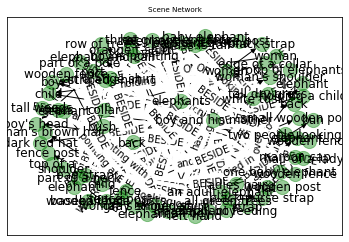

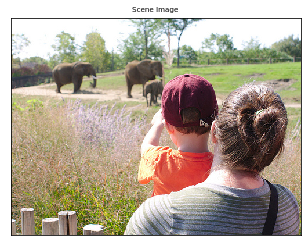

100%|██████████| 51/51 [00:00<00:00, 25517.06it/s]


Final selected graph and Image:


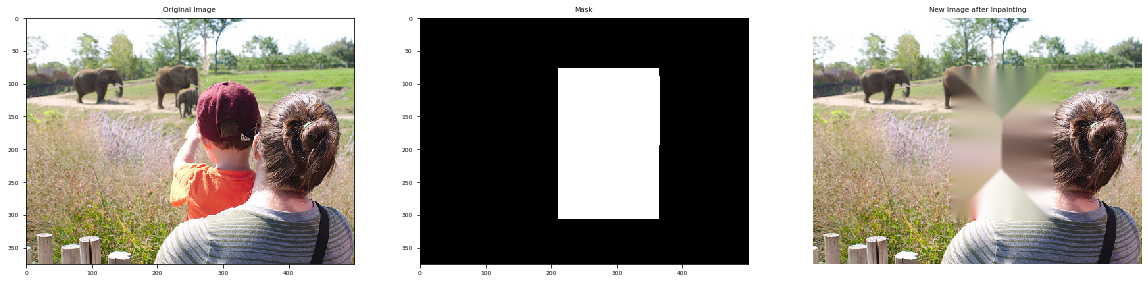

Note: Focus on the scene graph.


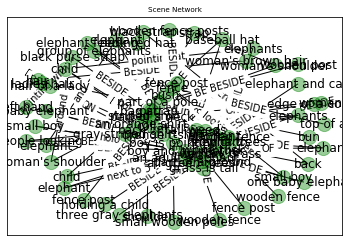

In [19]:
# Plot formatting
plt.rcParams['font.size'] = 6

  # Run program IMPORTANT
if __name__ == "__main__":
    perl = ["elephant"] # The main peference HERE
    for element in perl:
        try:
            # Load in data

                important_graphs = graph_reader(element)
        except:
            # Create data
            create_selected_graphs(element)
            # Load in data
            important_graphs = graph_reader(element) 

    X,labels = get_data_labels(important_graphs,virtual_user5)
    model = machine_learing_algorithm(X,labels,False)
    gl = get_correct_graphs(X,model,important_graphs)
    chosen_one = random.choice(gl).copy()
    print("Original selected graph and Image:")
    visualize_network(chosen_one,image=True)

    sample_graphs = generate_sample_graphs(chosen_one)
    X,labels = get_data_labels(sample_graphs,virtual_user5)
    
    try:
        final_graph_list = []
        final_R_list = []
        model = machine_learing_algorithm(X,labels,False)
        gl2 = get_correct_graphs(X,model,sample_graphs)
        temp = get_preferred_node_ids(chosen_one)
        for chosen_sample_graph in gl2:
            R = chosen_one.copy()
            R.remove_nodes_from(n for n in chosen_one if n in chosen_sample_graph)
            
            
            if R.nodes not in temp:
                final_graph_list.append(chosen_sample_graph)
                final_R_list.append(R)
         
        final_sample_graph = random.choice(final_graph_list)
        temp_R = final_graph_list.index(temp_sample_graph)
        

        final_R = final_R_list[temp_R]
        print("Final selected graph and Image:")
        show_new_image(chosen_one,final_R)
        print("Note: Focus on the scene graph.")
        visualize_network(final_sample_graph,False)
        
    except AttributeError:
        print("Final selected graph and Image:")
        visualize_network(chosen_one,image=True)
    
    except:
        chosen_sample_graph = random.choice(sample_graphs)
        temp = get_preferred_node_ids(chosen_sample_graph)
        R = chosen_one.copy()
        R.remove_nodes_from(n for n in chosen_one if n in chosen_sample_graph)
        print("Final selected graph and Image:")
        if R.nodes not in temp:
            show_new_image(chosen_one,R)
            print("Note: Focus on the scene graph.")
            visualize_network(chosen_sample_graph,False)


